# Import Libraries


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


# Import Dataset & Preprocessing

In [7]:
# Load dataset
data = pd.read_csv('C:/Users/HP/parkinsons.csv')

# Display basic information about the dataset
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

# Data Cleaning and Normalization

##### Handle Missing Values and Normalize Data





In [25]:
# Check for missing values
print(data.isnull().sum())

# Drop columns that are not relevant or cannot be normalized 
data_cleaned = data.drop(columns=['name'])

# Normalize using Z-score normalization
scaler = StandardScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_cleaned), columns=data_cleaned.columns)

name                   0
MDVP:Fo(Hz)            0
MDVP:Fhi(Hz)           0
MDVP:Flo(Hz)           0
MDVP:Jitter(%)         0
MDVP:Jitter(Abs)       0
MDVP:RAP               0
MDVP:PPQ               0
Jitter:DDP             0
MDVP:Shimmer           0
MDVP:Shimmer(dB)       0
Shimmer:APQ3           0
Shimmer:APQ5           0
MDVP:APQ               0
Shimmer:DDA            0
NHR                    0
HNR                    0
status                 0
RPDE                   0
DFA                    0
spread1                0
spread2                0
D2                     0
PPE                    0
Z-score Outlier        0
Mahalanobis Outlier    0
LOF Outlier            0
dtype: int64


# Method Implementations

### (a) Z-Score Based Anomaly Detection

In [30]:
# Calculate Z-scores
z_scores = np.abs(data_normalized)
threshold = 3
outliers_zscore = np.where(z_scores > threshold)

data['Z-score Outlier'] = (z_scores.max(axis=1) > threshold).astype(int)
print("Z-score Outliers:", np.sum(outliers_zscore))

Z-score Outliers: 13402


### (b) Mahalanobis Distance-Based Anomaly Detection

In [33]:
def calculate_mahalanobis(data):
    cov_matrix = np.cov(data, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean_values = np.mean(data, axis=0)
    mahalanobis_dist = []
    
    for i in range(len(data)):
        mahalanobis_dist.append(mahalanobis(data.iloc[i], mean_values, inv_cov_matrix))
    
    return np.array(mahalanobis_dist)

mahalanobis_dist = calculate_mahalanobis(data_normalized)
threshold = np.percentile(mahalanobis_dist, 95) 
outliers_mahalanobis = np.where(mahalanobis_dist > threshold)

data['Mahalanobis Outlier'] = (mahalanobis_dist > threshold).astype(int)
print("Mahalanobis Outliers:", np.sum(outliers_mahalanobis))

Mahalanobis Outliers: 1394


### (c) Local Outlier Factor (LOF)

In [36]:
lof = LocalOutlierFactor(n_neighbors=20)
outliers_lof = lof.fit_predict(data_normalized)

data['LOF Outlier'] = (outliers_lof == -1).astype(int)
print("LOF Outliers:", np.sum(outliers_lof))


LOF Outliers: 161


### (d) Isolation Forest


In [39]:
iso_forest = IsolationForest(contamination=0.05)
outliers_iso_forest = iso_forest.fit_predict(data_normalized)

data['Isolation Forest Outlier'] = (outliers_iso_forest == -1).astype(int)
print("Isolation Forest Outliers:", np.sum(outliers_iso_forest))


Isolation Forest Outliers: 175


C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


### (e) One-Class SVM

In [42]:
oc_svm = OneClassSVM(nu=0.05)
svm_outliers = oc_svm.fit_predict(data_normalized)
data['One-Class SVM Outlier'] = (svm_outliers == -1).astype(int)
print("One-Class SVM Outliers:", np.sum(svm_outliers))


One-Class SVM Outliers: 153


# Comparison and Evaluation

### Calculate Performance Metrics



In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Evaluation and Comparison
methods = ['Z-score Outlier', 'Mahalanobis Outlier', 'LOF Outlier', 'Isolation Forest Outlier', 'One-Class SVM Outlier']

for method in methods:
    print(f"\n{method} Evaluation")
    print(classification_report(data['status'], data[method]))
    print("Confusion Matrix:\n", confusion_matrix(data['status'], data[method]))
    accuracy = accuracy_score(data['status'], data[method])
    precision = precision_score(data['status'], data[method])
    recall = recall_score(data['status'], data[method])
    f1 = f1_score(data['status'], data[method])
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")


Z-score Outlier Evaluation
              precision    recall  f1-score   support

           0       0.25      0.94      0.40        48
           1       0.82      0.10      0.17       147

    accuracy                           0.30       195
   macro avg       0.54      0.52      0.28       195
weighted avg       0.68      0.30      0.23       195

Confusion Matrix:
 [[ 45   3]
 [133  14]]
Accuracy: 0.3026
Precision: 0.8235
Recall: 0.0952
F1-score: 0.1707

Mahalanobis Outlier Evaluation
              precision    recall  f1-score   support

           0       0.25      0.98      0.40        48
           1       0.90      0.06      0.11       147

    accuracy                           0.29       195
   macro avg       0.58      0.52      0.26       195
weighted avg       0.74      0.29      0.19       195

Confusion Matrix:
 [[ 47   1]
 [138   9]]
Accuracy: 0.2872
Precision: 0.9000
Recall: 0.0612
F1-score: 0.1146

LOF Outlier Evaluation
              precision    recall  f1-score 

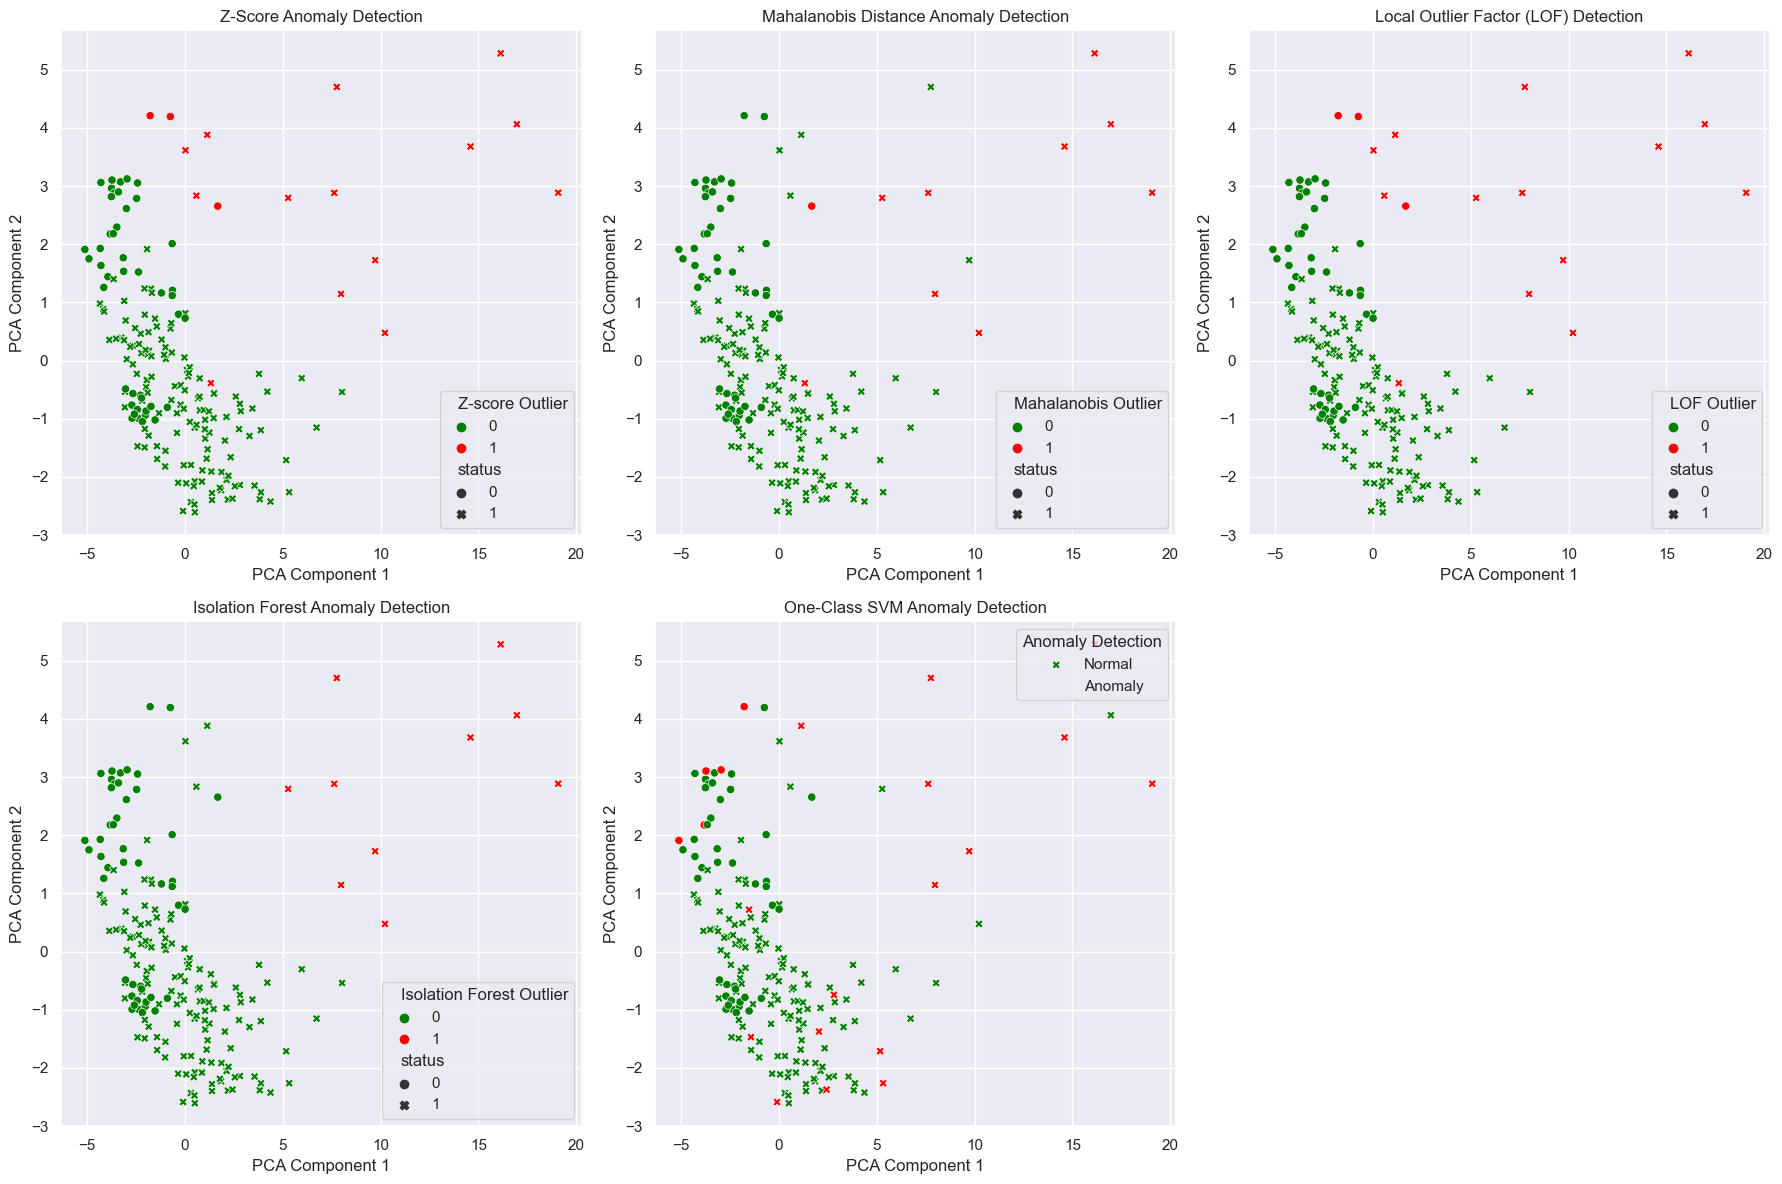

In [56]:
# Visualization of Anomalies
from sklearn.decomposition import PCA
# Principal Component Analysis (PCA)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(data_normalized.drop(columns=['status']))

# Plotting the anomalies
plt.figure(figsize=(18, 12))
sns.set(style="darkgrid")

palette = {0: 'green', 1: 'red'}

plt.subplot(2, 3, 1)
plt.title("Z-Score Anomaly Detection")
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=data['Z-score Outlier'], palette=palette, style=data['status'])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.subplot(2, 3, 2)
plt.title("Mahalanobis Distance Anomaly Detection")
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=data['Mahalanobis Outlier'], palette=palette, style=data['status'])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.subplot(2, 3, 3)
plt.title("Local Outlier Factor (LOF) Detection")
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=data['LOF Outlier'], palette=palette, style=data['status'])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.subplot(2, 3, 4)
plt.title("Isolation Forest Anomaly Detection")
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=data['Isolation Forest Outlier'], palette=palette, style=data['status'])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.subplot(2, 3, 5)
plt.title("One-Class SVM Anomaly Detection")
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=data['One-Class SVM Outlier'], palette=palette, style=data['status'])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.legend(title="Anomaly Detection", loc="upper right", labels=["Normal", "Anomaly"])
plt.show()
